<a href="https://colab.research.google.com/github/tijazz/Image_Processing/blob/main/Alzheimer_model_vgg16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os


import copy
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
import cv2
import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img, img_to_array
import matplotlib
import matplotlib.pylab as plt
import numpy as np
import seaborn as sns
import shap
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

from sklearn.model_selection import train_test_split

from keras.applications.vgg16 import VGG16,preprocess_input

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


In [ ]:
!unzip -uq "/content/Alzheimer_Dataset.zip" -d "/content/"
print("The file has been unzipped successfully")

The file has been unzipped successfully


In [ ]:
W = 224 #weight
H = 224 #height
#168

label_to_class = {
    'MildDemented': 0,
    'ModerateDemented': 1,
    'NonDemented': 2,
    'VeryMildDemented':3
    

}
class_to_label = {v: k for k, v in label_to_class.items()}
n_classes = len(label_to_class)

def get_images(dir_name='/content/Alzheimer_Dataset', label_to_class=label_to_class):
    """read images / labels from directory"""
    
    Images = []
    Classes = []
    
    for j in ['/train','/test']:
        for label_name in os.listdir(dir_name+str(j)):
            cls = label_to_class[label_name]

            for img_name in os.listdir('/'.join([dir_name+str(j), label_name])):
                img = load_img('/'.join([dir_name+str(j), label_name, img_name]), target_size=(W, H))
                img = img_to_array(img)

                Images.append(img)
                Classes.append(cls)
            
    Images = np.array(Images, dtype=np.float32)
    Classes = np.array(Classes, dtype=np.float32)
    Images, Classes = shuffle(Images, Classes, random_state=0)
    
    return Images, Classes

In [ ]:
## get images / labels
Images, Classes = get_images()

Images.shape, Classes.shape

((6400, 224, 224, 3), (6400,))

In [ ]:
## split train / test

indices_train, indices_test = train_test_split(list(range(Images.shape[0])), train_size=0.8, test_size=0.2, shuffle=False)

x_train = Images[indices_train]
y_train = Classes[indices_train]
x_test = Images[indices_test]
y_test = Classes[indices_test]

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((5120, 224, 224, 3), (5120,), (1280, 224, 224, 3), (1280,))

In [ ]:
from keras.utils import np_utils
## to one-hot

y_train = keras.utils.np_utils.to_categorical(y_train, n_classes)
y_test = keras.utils.np_utils.to_categorical(y_test, n_classes)

y_train.shape, y_test.shape

((5120, 4), (1280, 4))

In [ ]:
## to image data generator

datagen_train = ImageDataGenerator(
    preprocessing_function=preprocess_input, # image preprocessing function
    rotation_range=30,                       # randomly rotate images in the range
    width_shift_range=0.1,                   # randomly shift images horizontally
    height_shift_range=0.1,                  # randomly shift images vertically
    horizontal_flip=True,                    # randomly flip images horizontally
    vertical_flip=False,                     # randomly flip images vertically
)
datagen_test = ImageDataGenerator(
    preprocessing_function=preprocess_input, # image preprocessing function
)

In [ ]:
# example of loading the vgg16 model
from keras.applications.vgg16 import VGG16
from keras.layers import Flatten, Dense
import keras
# load model
model = keras.models.Sequential()

# load model
VGG = VGG16(include_top=False, input_shape=(W,H,3),pooling='avg')    
print(VGG.summary())
# Freezing Layers

for layer in VGG.layers:
    layer.trainable=False
    
model.add(VGG)
model.add(Flatten())
model.add(Dense(512,activation='relu',kernel_initializer='he_uniform'))
model.add(Dense(128,activation='relu',kernel_initializer='he_uniform'))
model.add(Dense(32,activation='relu',kernel_initializer='he_uniform'))
model.add(Dense(n_classes,activation='softmax'))
model.summary()

58889256/58889256 [==============================] - 2s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 32)                4128      
                                                                 
 dense_3 (Dense)             (None, 4)                 132       
                                                                 
Total params: 15,047,268
Trainable params: 332,580
Non-t

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [ ]:
#checkpoint_filepath = '{epoch:02d}-{val_loss:.7f}.hdf5'
checkpoint_filepath = '{epoch:02d}.h5'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1,
    save_best_only=True)

earlystop = EarlyStopping(monitor = 'val_accuracy', 
                          min_delta = 0, 
                          patience = 5,
                          verbose = 1,
                          mode='auto')

reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy',
                              factor = 0.2,
                              patience = 3,
                              verbose = 1,
                              min_delta = 0.0001)

# we put our call backs into a callback list
callbacks = [earlystop, model_checkpoint_callback, reduce_lr]

In [ ]:
#The metrics for our Model Evaluation 

METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc')
]

In [ ]:
#model epochs = 100 (default )

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=METRICS)

epochs = 10
history=model.fit(datagen_train.flow(x_train,y_train, batch_size=128,shuffle=True), 
                  epochs=epochs,validation_data=datagen_test.flow(x_test,y_test, batch_size=32,shuffle=True), callbacks=callbacks )

Epoch 1/10
40/40 [==============================] - ETA: 0s - loss: 1.3871 - accuracy: 0.7607 - precision: 0.5297 - recall: 0.3820 - auc: 0.7664 
Epoch 1: val_accuracy improved from -inf to 0.74766, saving model to 01.h5
40/40 [==============================] - 2628s 66s/step - loss: 1.3871 - accuracy: 0.7607 - precision: 0.5297 - recall: 0.3820 - auc: 0.7664 - val_loss: 1.0683 - val_accuracy: 0.7477 - val_precision: 0.4928 - val_recall: 0.3203 - val_auc: 0.7737 - lr: 0.0010
Epoch 2/10
40/40 [==============================] - ETA: 0s - loss: 0.9157 - accuracy: 0.7965 - precision: 0.6695 - recall: 0.3672 - auc: 0.8394 
Epoch 2: val_accuracy improved from 0.74766 to 0.79805, saving model to 02.h5
40/40 [==============================] - 2809s 71s/step - loss: 0.9157 - accuracy: 0.7965 - precision: 0.6695 - recall: 0.3672 - auc: 0.8394 - val_loss: 0.9429 - val_accuracy: 0.7980 - val_precision: 0.6349 - val_recall: 0.4523 - val_auc: 0.8394 - lr: 0.0010
Epoch 3/10
40/40 [===================

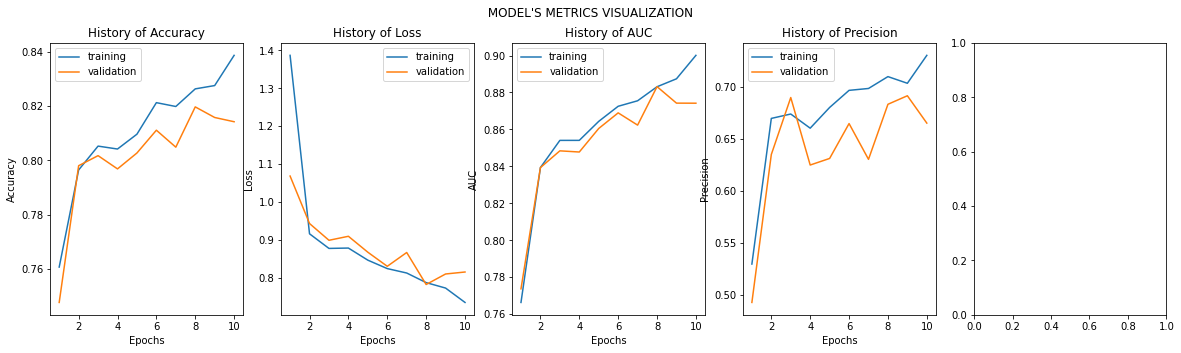

In [ ]:
#%% PLOTTING RESULTS (Train vs Validation FOLDER 1)

def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision):
    
    fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])
    

    plt.show()
    

Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'],
               history.history['auc'],history.history['val_auc'],
               history.history['precision'],history.history['val_precision']              
               )


In [ ]:
#Model Predictions

predictions=model.predict(x_test)

np.array(predictions)
CATEGORIES = ['MildDemented','ModerateDemented','NonDemented','VeryMildDemented']


40/40 [==============================] - 537s 13s/step


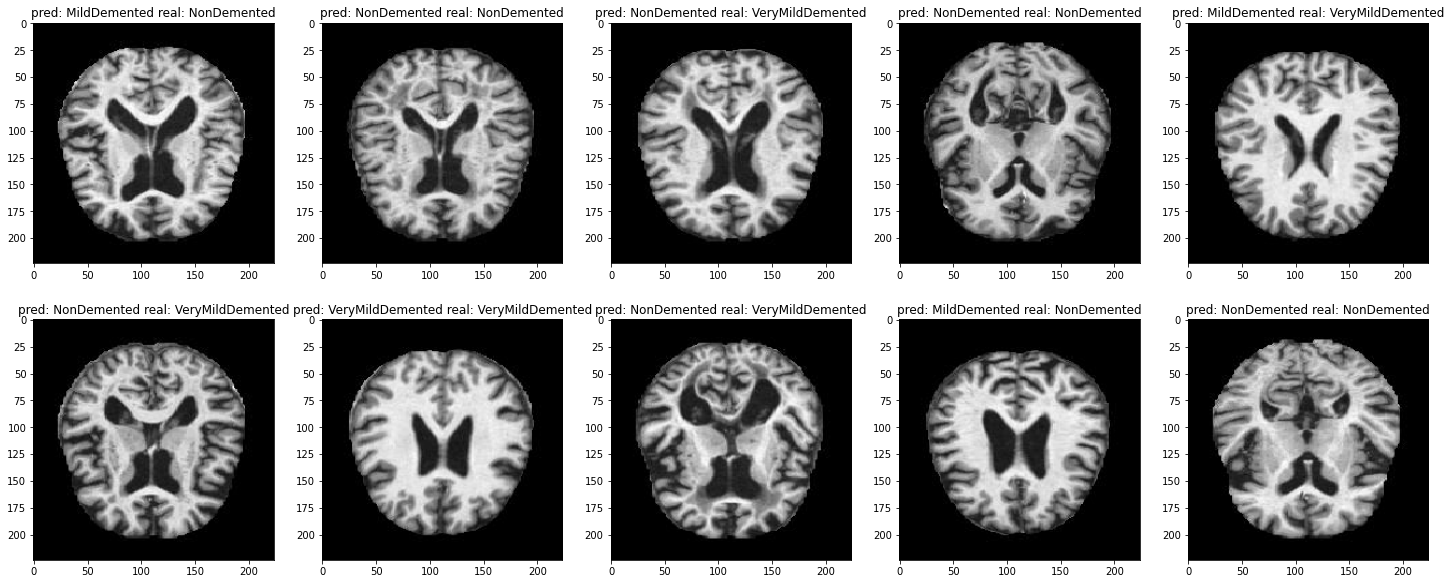

In [ ]:
#Confirming the results of our predictions against the real image for 10 random samples

rows = 2
columns = 5
fig, axs= plt.subplots(rows, columns , figsize=(25, 10))
axs = axs.flatten()
i=10
for a in axs:
    
    Image = Images[i]
    pred_label=predictions.argmax(axis=1)[i]
    actual_label=y_test.argmax(axis=1)[i]
    pred_label=CATEGORIES[pred_label]
    actual_label=CATEGORIES[actual_label]
    label= 'pred: '+ pred_label +' '+'real: '+ actual_label
    #axs[i](rows,columns,i)
    a.imshow(np.uint8(Image))
    a.set_title(label)
    i=i+1

plt.show()

40/40 [==============================] - 536s 13s/step


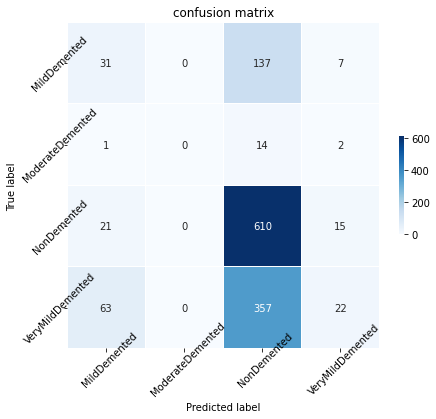

In [ ]:
## plot confusion matrix
y_preds = model.predict(x_test)
y_preds = np.argmax(y_preds, axis=1)
y_trues = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_trues, y_preds)

fig, ax = plt.subplots(figsize=(7, 6))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar_kws={'shrink': .3}, linewidths=.1, ax=ax)

ax.set(
    xticklabels=list(label_to_class.keys()),
    yticklabels=list(label_to_class.keys()),
    title='confusion matrix',
    ylabel='True label',
    xlabel='Predicted label'
)
params = dict(rotation=45, ha='center', rotation_mode='anchor')
plt.setp(ax.get_yticklabels(), **params)
plt.setp(ax.get_xticklabels(), **params)
plt.show()

In [ ]:
# Display our F1 Score results

print("F1 Score (testing): %.2f%%"% (f1_score(y_trues, y_preds, average='weighted')*100.0))

F1 Score (testing): 40.93%


In [ ]:
# Display our model accuracy results

print("accuracy (testing): %.2f%%"% (accuracy_score(y_trues, y_preds)*100.0))

accuracy (testing): 51.80%


In [ ]:
# Display our model classification report

report = classification_report(y_trues, y_preds)
print(report)

              precision    recall  f1-score   support

           0       0.27      0.18      0.21       175
           1       0.00      0.00      0.00        17
           2       0.55      0.94      0.69       646
           3       0.48      0.05      0.09       442

    accuracy                           0.52      1280
   macro avg       0.32      0.29      0.25      1280
weighted avg       0.48      0.52      0.41      1280

